# install required libraries

In [96]:
%pip install pandas-gbq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 39.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.0
    Uninstalling pyarrow-10.0.0:
      Successfully uninstalled pyarrow-10.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.8.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.65.0 which is incompatible.
tfx-bsl 1.8.0 requires pyarrow<6,>=1, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.8.0 requires pyarrow<6,>=1, but you have pyarrow 9.0.0 which is incompatible.
apache-beam 2.42.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 9.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install bokeh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 60.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install pandas_bokeh

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


# load libraries

In [9]:
from bokeh.io import output_notebook, show
from bokeh.models import Circle, ColumnDataSource, HoverTool, MultiLine, Range1d
from bokeh.plotting import figure, from_networkx
from google.cloud import bigquery
import networkx as nx
import numpy as np
import pandas as pd
import pandas_bokeh as pb
import random
from scipy.special import binom
from sys import stderr
from tabulate import tabulate

# read in edges sql query

In [55]:
with open('edges.sql', 'r') as f:
    query = f.read()
f.close()

# execute edges sql, retrieve results to dataframe

In [56]:
client = bigquery.Client()
df = client.query(query).to_dataframe()

In [57]:
#df = df.rename(columns={'num_claims': 'e'})
df['num_claims'] = df['num_claims'].astype(int)
df

,uid,source,target,date,num_claims
0,5391821,fl:hi_ln:koyama-33,c0c8f35d-998e-412e-ae9f-d7fa6510abb6,1995-02-21,99
1,6215065,fl:al_ln:cox-12,a60f0553-cd92-402c-b000-aab9a33f387c,2001-04-10,99
2,5009973,fl:sa_ln:yoshida-22,1b6fc2a6-9128-42d7-b4fc-0b8fa04733b5,1991-04-23,99
3,5290269,fl:ma_ln:heiman-1,c9d2e9ca-ea50-4b7a-9ff9-580f8b643bd4,1994-03-01,99
4,6460417,fl:ra_ln:potyrailo-1,c3d9c587-99c9-4087-87c7-89d9a1038656,2002-10-08,99
...,...,...,...,...,...
7115043,D724495,fl:ma_ln:majdandzic-1,7e09e3cb-d8a1-4456-b5d8-a6dc08c2226e,2015-03-17,1
7115044,D811493,fl:st_ln:walterscheid-2,f732f476-6b40-42d5-87d8-0cd11e3ed56f,2018-02-27,1
7115045,D519144,fl:te_ln:kato-21,256ce24b-a535-4b25-96f9-ea7f8c1fa74d,2006-04-18,1
7115046,D528856,fl:cu_ln:pascal-1,5b39e708-c10a-4f25-a3c5-a8318c02ecb4,2006-09-26,1


# read in nodes sql query

In [58]:
with open('nodes.sql', 'r') as f:
    query = f.read()
f.close()

nodes = client.query(query).to_dataframe()

# examine distribution of raw edge counts
### large hills and valleys may present challenges to convergences

<AxesSubplot:ylabel='Frequency'>

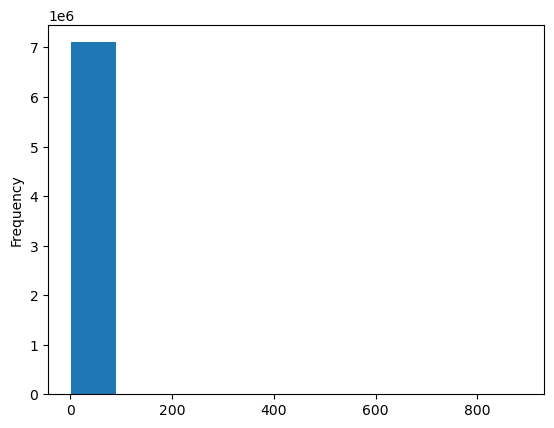

In [90]:
df['num_claims'].plot(kind='hist')

# This presents a challenge.
### Lower citation counts are completely dominating the distribution. Let's examine with a log transformation

<AxesSubplot:ylabel='Frequency'>

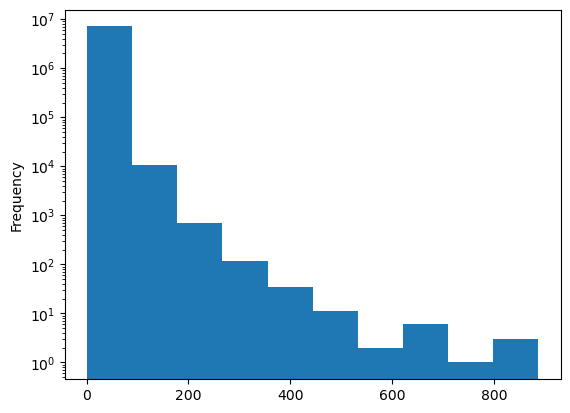

In [91]:
df['num_claims'].plot(kind='hist', logy=True)

# much better.
### let's implement a base ten log transformation against the data and plot a straight frequency distribution

In [69]:
df['e'] = df['num_claims'].apply(lambda x: np.log10(x))

<AxesSubplot:ylabel='Frequency'>

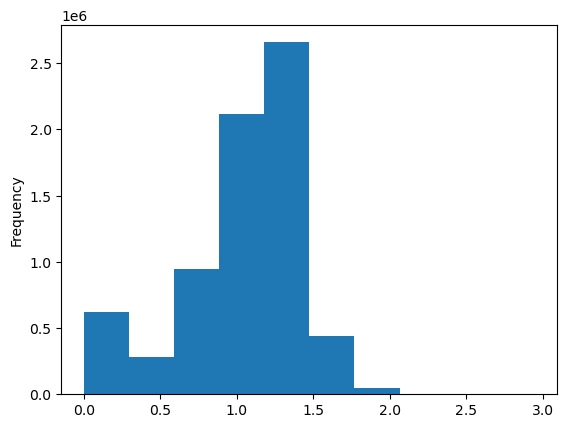

In [70]:
df['e'].plot(kind='hist')

In [71]:
df

,uid,source,target,date,num_claims,e
0,5391821,fl:hi_ln:koyama-33,c0c8f35d-998e-412e-ae9f-d7fa6510abb6,1995-02-21,99,1.995635
1,6215065,fl:al_ln:cox-12,a60f0553-cd92-402c-b000-aab9a33f387c,2001-04-10,99,1.995635
2,5009973,fl:sa_ln:yoshida-22,1b6fc2a6-9128-42d7-b4fc-0b8fa04733b5,1991-04-23,99,1.995635
3,5290269,fl:ma_ln:heiman-1,c9d2e9ca-ea50-4b7a-9ff9-580f8b643bd4,1994-03-01,99,1.995635
4,6460417,fl:ra_ln:potyrailo-1,c3d9c587-99c9-4087-87c7-89d9a1038656,2002-10-08,99,1.995635
...,...,...,...,...,...,...
7115043,D724495,fl:ma_ln:majdandzic-1,7e09e3cb-d8a1-4456-b5d8-a6dc08c2226e,2015-03-17,1,0.000000
7115044,D811493,fl:st_ln:walterscheid-2,f732f476-6b40-42d5-87d8-0cd11e3ed56f,2018-02-27,1,0.000000
7115045,D519144,fl:te_ln:kato-21,256ce24b-a535-4b25-96f9-ea7f8c1fa74d,2006-04-18,1,0.000000
7115046,D528856,fl:cu_ln:pascal-1,5b39e708-c10a-4f25-a3c5-a8318c02ecb4,2006-09-26,1,0.000000


# set required outer values for NGTA

In [72]:
measurement_count = max(df['e'])
node_count = len(nodes)
edge_count = len(df)

2.9479236198317262

# Success. Now let's run newman's algorithm

In [73]:
# set random initial value for alpha, beta, rho
alpha = beta = rho = 0.5*random.random()

# store stepwise alpha, beta, rho values as they converge
_alpha, _beta, _rho = [], [], []

# run the algorithm
for r in range(3):
    print(r)
    df['q'] = df.apply(lambda row: rho*(alpha**row['e'])*(1-alpha)**(measurement_count - row['e'])/ \
                       (rho*(alpha**row['e'])*(1-alpha)**(measurement_count-row['e']) + \
                       (1-rho)*(beta**row['e'])*(1-beta)**(measurement_count-row['e'])), axis=1)
    
    df['eq'] = df.apply(lambda row: row['e']* row['q'], axis=1)
    
    alpha = df['eq'].sum() / (measurement_count*df['q'].sum())
    _alpha.append(alpha)
    
    beta = (df['e'].sum()-df['eq'].sum()) / (measurement_count*(binom(node_count, 2)-df['q'].sum()))
    _beta.append(beta)
    
    rho = df['q'].sum() / binom(node_count, 2)
    _rho.append(rho)

# with converged alpha, beta, and rho values, we can calculate a false-discovery rate for the network
fdr = ((1-rho)*beta)/((rho*alpha) + ((1-rho)*beta))

# rounded values for display only
r_fdr, r_alpha, r_beta = round(fdr, 2), round(alpha, 4), round(beta, 4)

0
1
2


In [74]:
print(f'alpha (network average true positive rate): {alpha}')
print(f'beta (network average false positive rate): {beta}')
print(f'False Discovery rate: {fdr}')

alpha (network average true positive rate): 0.4321600082282091
beta (network average false positive rate): 6.668164745604011e-08
False Discovery rate: 0.23438247210144172


# load network level metastatistics to bigquery

In [102]:
meta_df = pd.DataFrame.from_dict({'true_positive': alpha, 'false_positive': beta, 'false_discovery': fdr}, orient='index').reset_index().rename(columns={'index': 'stat', 0: 'value'})
meta_df

,stat,value
0,true_positive,4.321600e-01
1,false_positive,6.668165e-08
2,false_discovery,2.343825e-01


In [103]:
meta_df.to_gbq('master.meta_ngta')

100%|██████████| 1/1 [00:00<00:00, 9157.87it/s]


In [75]:
df

,uid,source,target,date,num_claims,e,q,eq
0,5391821,fl:hi_ln:koyama-33,c0c8f35d-998e-412e-ae9f-d7fa6510abb6,1995-02-21,99,1.995635,9.999998e-01,1.995635
1,6215065,fl:al_ln:cox-12,a60f0553-cd92-402c-b000-aab9a33f387c,2001-04-10,99,1.995635,9.999998e-01,1.995635
2,5009973,fl:sa_ln:yoshida-22,1b6fc2a6-9128-42d7-b4fc-0b8fa04733b5,1991-04-23,99,1.995635,9.999998e-01,1.995635
3,5290269,fl:ma_ln:heiman-1,c9d2e9ca-ea50-4b7a-9ff9-580f8b643bd4,1994-03-01,99,1.995635,9.999998e-01,1.995635
4,6460417,fl:ra_ln:potyrailo-1,c3d9c587-99c9-4087-87c7-89d9a1038656,2002-10-08,99,1.995635,9.999998e-01,1.995635
...,...,...,...,...,...,...,...,...
7115043,D724495,fl:ma_ln:majdandzic-1,7e09e3cb-d8a1-4456-b5d8-a6dc08c2226e,2015-03-17,1,0.000000,8.266389e-08,0.000000
7115044,D811493,fl:st_ln:walterscheid-2,f732f476-6b40-42d5-87d8-0cd11e3ed56f,2018-02-27,1,0.000000,8.266389e-08,0.000000
7115045,D519144,fl:te_ln:kato-21,256ce24b-a535-4b25-96f9-ea7f8c1fa74d,2006-04-18,1,0.000000,8.266389e-08,0.000000
7115046,D528856,fl:cu_ln:pascal-1,5b39e708-c10a-4f25-a3c5-a8318c02ecb4,2006-09-26,1,0.000000,8.266389e-08,0.000000


# examine alpha, beta, and rho's convergences

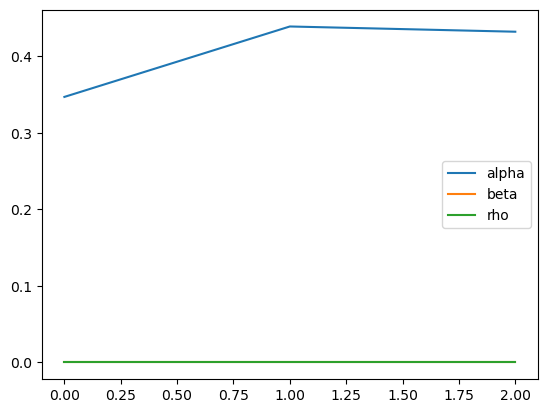

In [76]:
df2 = pd.DataFrame(list(zip(_alpha, _beta, _rho)), columns=['alpha', 'beta', 'rho'])
lines = df2.plot.line()

# plot edge-level confidence metrics distribution

<AxesSubplot:ylabel='Frequency'>

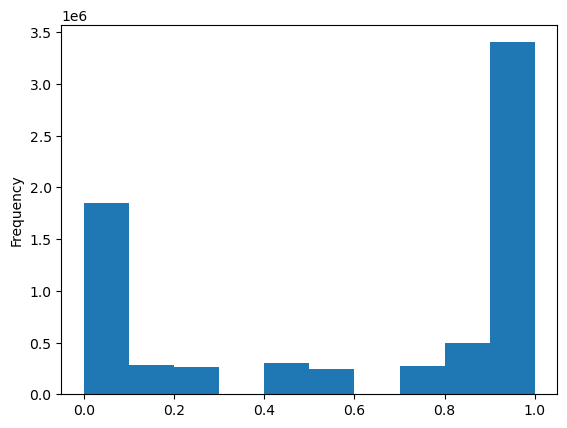

In [77]:
df['q'].plot(kind='hist')

# how do additional measurements affect our overall network confidence?

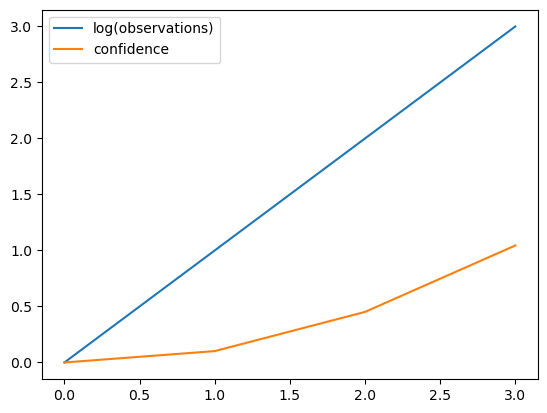

In [89]:
df3 = pd.DataFrame(list(zip([e for e in np.arange(0, measurement_count+1)],
                            [rho*(alpha**measurement_count)*(1-alpha)**(measurement_count-e) / \
                             (rho*(alpha**e)*(1-alpha)**(measurement_count-e) + \
                              (1-rho)*(beta**e)*(1-beta)**(measurement_count-e)) \
                             for e in np.arange(0, measurement_count+1)])),
                   columns=['log(observations)', 'confidence'])

lines = df3.plot.line()

# push results to bigquery

In [94]:
del df['eq']
del df['e']
df = df.rename(columns={'q': 'confidence'})
df

,uid,source,target,date,num_claims,confidence
0,5391821,fl:hi_ln:koyama-33,c0c8f35d-998e-412e-ae9f-d7fa6510abb6,1995-02-21,99,9.999998e-01
1,6215065,fl:al_ln:cox-12,a60f0553-cd92-402c-b000-aab9a33f387c,2001-04-10,99,9.999998e-01
2,5009973,fl:sa_ln:yoshida-22,1b6fc2a6-9128-42d7-b4fc-0b8fa04733b5,1991-04-23,99,9.999998e-01
3,5290269,fl:ma_ln:heiman-1,c9d2e9ca-ea50-4b7a-9ff9-580f8b643bd4,1994-03-01,99,9.999998e-01
4,6460417,fl:ra_ln:potyrailo-1,c3d9c587-99c9-4087-87c7-89d9a1038656,2002-10-08,99,9.999998e-01
...,...,...,...,...,...,...
7115043,D724495,fl:ma_ln:majdandzic-1,7e09e3cb-d8a1-4456-b5d8-a6dc08c2226e,2015-03-17,1,8.266389e-08
7115044,D811493,fl:st_ln:walterscheid-2,f732f476-6b40-42d5-87d8-0cd11e3ed56f,2018-02-27,1,8.266389e-08
7115045,D519144,fl:te_ln:kato-21,256ce24b-a535-4b25-96f9-ea7f8c1fa74d,2006-04-18,1,8.266389e-08
7115046,D528856,fl:cu_ln:pascal-1,5b39e708-c10a-4f25-a3c5-a8318c02ecb4,2006-09-26,1,8.266389e-08


In [99]:
df.to_gbq('master.ngta')

100%|██████████| 1/1 [00:00<00:00, 8422.30it/s]


# takeaways
## alpha = network-average true positive rate. 
### a small alpha value implies many false negatives. ie, edges in the true network are not present in the data
## beta = network-average false positive rate
### a small beta value implies few false positives: an edge is rarely observed where none exists
## False Discovery Rate
### probability of an observed edge being false: a small false discovery rate implies that observed edges are part of the true network
## edge-level q values
### for each edge, our calculated q-value is the probability that the edge exists in the true network